<center><img src="Fig/Ensimag.png" width="30%" height="30%"></center>
<center><h3>Ensimag - 3A - IF</h3></center>
<hr>
<center><h1>Traitement des données hétérogènes</h1></center>
<center><h2>TP: Système de recommandation de films</h2></center>
<center><h3>Daniella Teukeng Mobou, Mylène Le Calvez</h3></center>
<center><h6>Date de rendu : 01/03/2019</h6></center>

<hr>

Un **système de recommandation** est défini comme une fonction qui prédit l'*attrait d'un utilisateur pour un produit*. Au cours des dernières années, nous avons assisté à l'explosion des quantités de données numériques circulant sur Internet : vidéos, articles, images etc. Les internautes désirent un accès à l'information rapide et pertinent : les systèmes de recommandations sont alors apparus comme essentiels pour de nombreuses plateformes web. Par exemple, **Netflix**, un site de streaming vidéo comptant plus de 65 millions d'utilisateurs à travers le monde, se devait de proposer à chaque profil un contenu adapté et cohérent parmi une grande variété de films et de séries. Les performances de leur système de recommandation sont un **enjeu majeur** pour cette entreprise, d’où la création d’un concours, "*The Netflix Prize*" qui, chaque année, permet aux participants de gagner *1 million de dollars* afin d’améliorer leur système de recommandation.

Des chercheurs de l'entreprise **IBM** ont gagné le concours en proposant une décomposition matricielle fondée sur l'algorithme de la descente de gradient, méthode très utilisée en apprentissage. 

Ce projet scolaire a pour but d'implémenter le modèle de la factorisation matricielle pour la recommandation de films. Nous utilisons les données disponibles sur le site MovieLens : https://grouplens.org/datasets/movielens/1m/. Plusieurs bases de données sont disponibles, celle que nous utilisons dans ce projet contient **1 million de notes d'utilisateurs (6000 utilisateurs pour environ 4000 films)**. Les utilisateurs notent les films entre 1 et 5. 

<hr>

# Prétraitement

Dans cette phase de prétraitement, nous allons séparer les données en deux groupes puis réaliser des analyses statistiques sur les données extraites de la base **MovieLens 1M**. L'efficacité des systèmes de recommandation est corrélée à leur capacité à manipuler des grandes quantités de données et à leur faculté à fournir les meilleurs recommandations pour un utilisateur donné. La matrice des scores est constituée en majorité (environ **98%**) par des  scores non-saisis, qui ne nous apporterons pas d'information pour le système de recommandation. Nous nous intéressons uniquement aux notes renseignées. 

## Scinder la base en deux parties : *Train* et *Test*

Nous scindons la base fournie par **MovieLens 1M** en deux parties : 

- **Train** (*données d'apprentissage*): Via un ensemble fini d'utilisateurs et de produits, nous allons pouvoir inférer le score d'apétence de la manière la plus générale possible : on part des données pour extraire des règles générales. Cette partie nous permettra de décomposer la matrice de *Notes* en un produit de matrices *Utilisateurs* et *Films*.

- **Test** (*données de test*): Nous allons ensuite tester la fonction apprise sur de nouvelles données, le but étant d'avoir le moins d'erreur possible. 

Par défaut, pour chaque utilisateur nous prenons **70%** des notes qu'il a attribué pour la partie **appprentissage** et **30%** des notes qu'il a attribué pour la partie **test**. 


In [28]:
# Importation du module pandas
import pandas as pd

In [29]:
# Lecture des fichiers
df = pd.read_csv("ratings.dat",
                 sep="::", #separateur
                 header=None, #pas d'en-tête
                 engine='python')

# Lecture du dataframe de la forme : 
#df[colonne][ligne]
#df[0] colonne user, df[1] colonne id film, df[2] colonne rate, df[3] colonne timestamp

In [30]:
# Creation des dataframes de train et test
data_training = pd.DataFrame()
data_test = pd.DataFrame()

# Creation du dictionnaire {utilisateurs:nb notes}
user_nbRating = {}

In [31]:
# Initialisation du numéro de l'utilisateur
currentUser = 1

# Initialisation du nombre de film qu'il a aimé
ratingUser = 0

# Remplissage du dictionnaire {utilisateurs:nb notes}
line = 0
while line < len(df) and df[0][line] == currentUser:
    ratingUser += 1
    line += 1
    if line < len(df) and df[0][line] != currentUser:
        user_nbRating[currentUser] = ratingUser
        ratingUser = 0
        currentUser = df[0][line]
# Pour le dernier utilisateur
user_nbRating[currentUser] = ratingUser

In [32]:
# Remplissage des dataframe test et apprentissage
ligne = 0
for user_id in user_nbRating:
    data_training_user = pd.DataFrame()
    data_test_user = pd.DataFrame()
    index = int(0.7 * user_nbRating[user_id])
    data_training_user = df.loc[ligne:index+ligne-1,]
    data_test_user = df.loc[index + ligne : ligne + user_nbRating[user_id],]
    data_training = pd.concat([data_training, data_training_user])
    data_test = pd.concat([data_test, data_test_user])
    ligne = ligne + user_nbRating[user_id]

*Remarque* : Pour changer la proportion de données dans la partie **apprentissage** et **test**, il suffit de modifier le **0.7** du code précédent par la proportion souhaitée en apprentissage. 

In [33]:
# Creation de fichiers contenant les données test et apprentissage
data_training.to_csv('data_training.dat', sep=':',header=None, index = False)
data_test.to_csv('data_test.dat', sep=':',header=None, index = False)

## Analyses statistiques 

Dans cette partie, nous allons analyser les données fournies par la base de données **MovieLens 1M** : distribution des *notes* dans la partie **apprentissage**, distribution des *notes* dans la partie **test** et distribution des *interactions films/utilisateurs* (nombre de films notés par un utilisateur). Nous étudierons les valeurs moyennes, maximales, minimales, médianes, les quartiles à 25% et 75% ainsi que les écart-types. Nous représenterons ensuite les données sous forme d'***histogramme*** et de ***boxplot*** pour avoir une vue d'ensemble de la répartition des données.

In [34]:
# Importation des modules nécessaires pour l'analyse statistique
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### Distribution des notes en *train*

Cette partie contient l'analyse statistique des données d'apprentissage. 

In [35]:
# Lecture du fichier de donnees train
df = pd.read_csv("data_training.dat",
                 sep=":", #separator whitespace
                 header=None, #none header
                 engine='python')

In [36]:
# Recuperation de la colonne des notes
Note = df[2]
# Tri des notes
Note = np.sort(Note)

In [37]:
print("Taille de l'échantillon :", len(Note))
print("Note moyenne :", np.mean(Note))
print("Note médiane :", np.median(Note))
print("Note maximale :", max(Note))
print("Note minimale :", min(Note))
print("Quartile 25% :", stats.scoreatpercentile(Note, 25))
print("Quartile 75% :", stats.scoreatpercentile(Note, 75))
print("L'écart type :", np.std(Note))
print("L'écart type non biasé :", np.std(Note, ddof=1))

Taille de l'échantillon : 697378
Note moyenne : 3.5750568558228104
Note médiane : 4.0
Note maximale : 5
Note minimale : 1
Quartile 25% : 3.0
Quartile 75% : 4.0
L'écart type : 1.1167078711351108
L'écart type non biasé : 1.116708671783448


C:\Users\Portable\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


L'échantillon d'apprentissage contient 697378 notes d'utilisateurs. Cela correspond à la somme des parties entières inférieures de 70% des notes attribuées par chaque utilisateur. Les notes sont comprises entre 1 et 5. La note moyenne attribuée par les utilisateurs est environ 3.575, ce qui est relativement élevé. Seulement 25% des notes attribuées par les utilisateurs sont inférieures ou égales à 3. La note médiane est 4, ce qui signifie que 50% des notes attribuées par les utilisateurs sont inférieures ou égales à 4. Le troisième quartile vaut également 4, ce qui signifique que 75% des notes sont inférieures ou égales à 4. La plupart des utilisateurs attribuent la note de 3 ou 4 aux films qu'ils jugent. L'écart-type, qui mesure la dispersion des données, vaut environ 1.12, ce qui montre encore une fois que les notes attribuées par les utilisateurs sont toujours relativement proches de la moyenne à 3.575. 

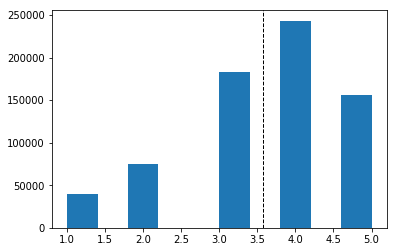

In [38]:
# Histogramme de distribution des notes en apprentissage
plt.hist(Note)
plt.axvline(Note.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

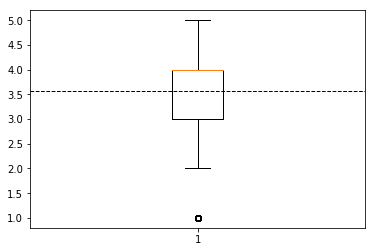

In [39]:
# Boxplot de distribution des notes en apprentissage

fig = plt.figure()
plt.xticks([0], ['Note'])
plt.axhline(Note.mean(), color='k', linestyle='dashed', linewidth=1)
plt.boxplot(Note)
plt.savefig('BoxPlot.png', bbox_inches='tight')
plt.show()

Comme attendu, la distribution des notes est assez déséquilibrée. Les notes sont majoritairement bonnes (supérieures ou égales à 3), avec un pic autour de la moyenne. Ces notes ne représentent pas forcément l'opinion générale des utilisateurs, puisque les utilisateurs ne notent pas tous les films qu'ils voient. Les utilisateurs semblent globalement noter les films qu'ils ont aimé. 

### Distribution des notes en *test*

Cette partie contient l'analyse statistique des données de test. 

In [40]:
# Lecture du fichier de donnees train
df = pd.read_csv("data_test.dat",
                 sep=":", #separator whitespace
                 header=None, #none header
                 engine='python')

In [41]:
# Recuperation de la colonne des notes
Note = df[2]
# Tri des notes
Note = np.sort(Note)

In [42]:
print("Taille de l'échantillon :", len(Note))
print("Note moyenne :", np.mean(Note))
print("Note médiane :", np.median(Note))
print("Note maximale :", max(Note))
print("Note minimale :", min(Note))
print("Quartile 25% :", stats.scoreatpercentile(Note, 25))
print("Quartile 75% :", stats.scoreatpercentile(Note, 75))
print("L'écart type :", np.std(Note))
print("L'écart type non biasé :", np.std(Note, ddof=1))

Taille de l'échantillon : 308870
Note moyenne : 3.598986628678732
Note médiane : 4.0
Note maximale : 5
Note minimale : 1
Quartile 25% : 3.0
Quartile 75% : 4.0
L'écart type : 1.1169034492894754
L'écart type non biasé : 1.1169052573416678


L'échantillon de test contient 308870 notes d'utilisateurs. Les notes sont comprises entre 1 et 5. La note moyenne attribuée par les utilisateurs est environ 3.599, ce qui est relativement élevé et très légèrement supérieur à la moyenne des notes en apprentissage. Seulement 25% des notes attribuées par les utilisateurs sont inférieures ou égales à 3. La note médiane est 4, ce qui signifie que 50% des notes attribuées par les utilisateurs sont inférieures ou égales à 4. Le troisième quartile vaut également 4, ce qui signifique que 75% des notes sont inférieures ou égales à 4. La plupart des utilisateurs attribuent la note de 3 ou 4 aux films qu'ils jugent. L'écart-type, qui mesure la dispersion des données, vaut environ 1.12, tout comme dans l'ensemble d'apprentissage, ce qui montre encore une fois que les notes attribuées par les utilisateurs sont toujours relativement proches de la moyenne. Les valeurs des notes de la partie test sont distribuées de la même manière que dans la partie apprentissage. 

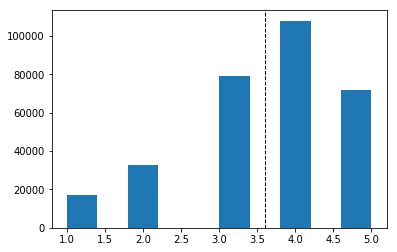

In [43]:
# Histogramme de distribution des notes en test

plt.hist(Note)
plt.axvline(Note.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

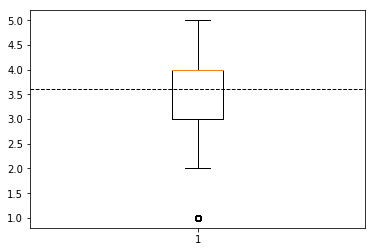

In [44]:
# Boxplot de distribution des notes en test

fig = plt.figure()
plt.xticks([0], ['Note'])
plt.axhline(Note.mean(), color='k', linestyle='dashed', linewidth=1)
plt.boxplot(Note)
plt.savefig('BoxPlot.png', bbox_inches='tight')
plt.show()

Nous pouvons tirer les mêmes conclusions que dans la partie apprentissage : la distribution des notes est assez déséquilibrée. Les notes sont majoritairement bonnes (supérieures ou égales à 3), avec un pic autour de la moyenne. 

### Distribution des interactions

Cette partie contient l'analyse statistique des interactions utilisateurs/films : nombre de films notés par utilisateur. 

In [45]:
# Recuperation des données grace au dictionnaire {utilisateurs:nb notes}
Interactions = [user_nbRating[user_id] for user_id in user_nbRating]

In [46]:
# Tri des données
Interactions = np.sort(Interactions)

In [47]:
print("Taille de l'échantillon :", len(Interactions))
print("Nombre d'interaction moyen :", np.mean(Interactions))
print("Nombre d'interaction médian :", np.median(Interactions))
print("Nombre d'interaction maximal :", max(Interactions))
print("Nombre d'interaction minimal :", min(Interactions))
print("Quartile 25% :", stats.scoreatpercentile(Interactions, 25))
print("Quartile 75% :", stats.scoreatpercentile(Interactions, 75))
print("L'écart type :", np.std(Interactions))
print("L'écart type non biasé :", np.std(Interactions, ddof=1))

Taille de l'échantillon : 6040
Nombre d'interaction moyen : 165.5975165562914
Nombre d'interaction médian : 96.0
Nombre d'interaction maximal : 2314
Nombre d'interaction minimal : 20
Quartile 25% : 44.0
Quartile 75% : 208.0
L'écart type : 192.73107252940773
L'écart type non biasé : 192.74702906977777


Dans la base de données étudiée, 6040 utilisateurs ont noté des films. Au minimum, les utilisateurs ont noté 20 films et au maximum ils ont noté 2314 films. Un utilisateur moyen note environ 165 films. 25% des utilisateurs ont noté au plus 44 films. 50% des utilisateurs ont noté au plus 96 films. 75% des utilisateurs ont noté au plus 208 films. On en déduit que les utilisateurs notant une grande quantité de films sont assez rare. Il faudrait avoir le nombre de films vus par chaque utilisateurs pour faire des conclusions plus certaines. L'écart-type, qui mesure la dispersion des données, vaut environ 192.7, ce qui est assez faible par rapport aux valeurs extrêmes : les données semblent bien regroupées autour de la moyenne. 

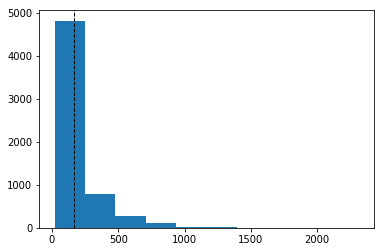

In [48]:
# Histogramme de distribution des interactions

plt.hist(Interactions)
plt.axvline(Interactions.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

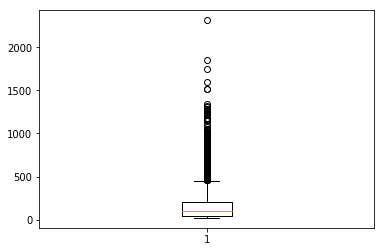

In [49]:
# Boxplot de distribution des interactions

fig = plt.figure()
plt.xticks([0], ['Interactions'])
plt.boxplot(Interactions)
plt.savefig('BoxPlot.png', bbox_inches='tight')
plt.show()

Les données sont réparties de manière hétérogène : la plupart sont regroupées autour de la moyenne, et quelques rares utilisateurs dispersés ont noté un très grand nombre de films. 

<hr>

# Phase d'apprentissage

## Présentation

On note N le nombre d'utilisateurs et M le nombre de scores donnés par l'utilisateur. On note A la matrice des scores, extraite précédemment. 
Le but de la phase d'apprentissage est de trouver les matrices de décomposition U et V qui approximent la matrice des notes de la partie ***train*** au sens du moindre carré. 
Nous cherchons les matrices 
$$U \in \mathbb{R}^{Nxk}$$ et $$V \in \mathbb{R}^{Mxk}$$ 
en minimisant l'erreur quadratique régularisée
$$\mathcal{L}(A, U, V) = \sum_{(u,i)\in A | A_{ui}observé}[(A_{ui}-U_u V_i^T )^2 + \lambda (||U_u||^2 + ||V_i||^2] $$
grâce à l'algorithme de descente de gradient.

## Algorithme de descente de gradient 

In [55]:
import collections as col

##### Création de la matrice A

La matrice A contient les notes attribués aux films par les utilisateurs. 

In [50]:
# Lecture du fichier des données d'apprentissage
df = pd.read_csv("data_training.dat",
                 sep=":", #separator whitespace
                 header=None)

nb_film = 4000
nb_user = 6040
A = np.zeros((nb_user, nb_film))

for line in range(0,len(df)):
    user_id = df[0][line] 
    film_id = df[1][line] 
    A[user_id - 1][film_id - 1] = df[2][line]

##### Calcul de la vraisemblance

In [51]:
#Fonction vraisemblance
def vraisemblance(A, U, V, Lambda) :
    value = 0
    #On sélectionne les couples (ligne, colonne) de la matrice A qui ont une note
    a = np.where(A != 0)
    ligne = a[0]
    colonne = a[1]
    for k in range(len(ligne)):
        u = ligne[k]
        i = colonne[k]
        Uu = U[u, :]
        Vi = V[i, :]
        scalar = np.vdot(Uu, Vi)
        norme1 = np.vdot(Uu, Uu)
        norme2 = np.vdot(Vi, Vi)
        value += ((A[u][i] - scalar)**2 + Lambda*(norme1 + norme2))
    return value

##### Calcul du gradient 

In [52]:
#Gradient de la vraisemblance selon le vecteur Uu
def gradient_U(Aui, Uu, Vi, Lambda):
    return(-2 * (Aui - np.vdot(Uu, Vi))*Vi + 2 * Lambda * Uu)

#Gradient de la vraisemblance selon le vecteur Vi
def gradient_V(Aui, Uu, Vi, Lambda):
    return(-2 * (Aui - np.vdot(Uu, Vi))*Uu + 2 * Lambda * Vi)

##### Méthode de descente du gradient 

In [53]:
def descenteGradient(A, U0, V0, eta, Lambda, epsilon):
    #Le nombre d'utilisateur
    nb_user = U0.shape[0]
    #Le nombre de film
    nb_film = V0.shape[0]
    #Le paramètre k
    k = U0.shape[1]
    #Initialisation des vecteurs pour la descente du gradient
    Uprec = np.copy(U0)
    Vprec = np.copy(V0)
    #Vecteurs dans lesquels on stocke les nouvelles valeurs de U et V
    U = np.zeros((nb_user, k), dtype=np.float64)
    V = np.zeros((nb_film, k), dtype=np.float64)
    #On sélectionne les couples (ligne, colonne) de la matrice A qui ont une note
    a = np.where(A != 0)
    ligne = a[0]
    colonne = a[1]
    ligne_distinct = col.Counter(ligne)
    col_distinct = col.Counter(colonne)
    #Calcul de la vraisemblance initiale
    vraisemblance_prec = vraisemblance(A, U0, V0,Lambda)
    k = 0
    while True:
        #On récupère les utilisateurs qui ont noté un film
        for u in ligne_distinct:
            indice_u = np.where(ligne == u)
            couple_ui = colonne[indice_u]
            vecteur_U = np.zeros(k)
            #Les films que a noté l'utilisateur i
            for i in couple_ui:
                vecteur_U = np.add(vecteur_U, gradient_U(A[u][i], Uprec[u,:], Vprec[i,:], Lambda))
            U[u, :] = np.add(Uprec[u,:], np.multiply(-eta, vecteur_U))
        #On récupère les films qui ont été noté
        for i in col_distinct:
            indice_i = np.where(colonne == i)
            couple_ui = ligne[indice_i]
            vecteur_V = np.zeros(k)
            #Les utilisateurs qui ont noté le film i
            for u in couple_ui:
                vecteur_V = np.add(vecteur_V, gradient_U(A[u][i], Uprec[u,:], Vprec[i,:], Lambda))
            V[i, :] = np.add(Vprec[i,:], np.multiply(-eta, vecteur_V))
        rec = vraisemblance(A, U, V,Lambda)
        diff = abs(rec - vraisemblance_prec)
        if diff > epsilon :
            Uprec = U
            Vprec = V
            vraisemblance_prec = rec
        else:
            break
        k = k + 1
    return U, V


##### Algorithme

In [56]:
k = 1
eta = 0.1
Lambda = 0.1
epsilon = 0.001
U_init = np.random.rand(nb_user, k)
V_init = np.random.rand(nb_film, k)
result = descenteGradient(A, U_init, V_init, eta, Lambda, epsilon)
print(result[0])
print(result[1])

ValueError: could not broadcast input array from shape (0) into shape (1)

<hr>

# Phase de test

## Mean Squared Error

L'erreur quadratique moyenne d'un estimateur, ou *Mean Sqared Error* (MSE), est une mesure caractérisant la « précision » de cet estimateur. Cette mesure sorrespond à la moyenne arithmétique des carrés des écarts entre les prévisions et les observations. Nous souhaitons la MSE la plus faible possible.

$$MSE = \frac{1}{N} \sum_{u=1}^N \frac{1}{M} \sum_{i=1}^M (A_{ui} - (U_u^* V_i^{*T}))^2 $$

## Mean Absolute Error 

L'erreur moyenne absolue d'un estimateur, ou *Mean Absolute Error* (MAE), est une mesure caractérisant la « précision » de cet estimateur. Cette mesure sorrespond à la moyenne arithmétique des écarts en valeur absolue entre les prévisions et les observations. Nous souhaitons la MSE la plus faible possible.

$$MSE = \frac{1}{N} \sum_{u=1}^N \frac{1}{M} \sum_{i=1}^M |A_{ui} - (U_u^* V_i^{*T})| $$

## Calculs

In [ ]:
def prediction(U, V, Atest):
    MAE = 0
    MSE = 0
    #On sélectionne les couples (user, film) de la matrice A qui ont une note
    a = np.where(Atest != 0)
    user = a[0]
    film = a[1]
    nb_user = U.shape[0]
    for u in range(nb_user):
        d = 0
        indice_u = np.where(user == u)
        couple_ui = film[indice_u]
        MAE_u = 0
        MSE_u = 0
        for i in couple_ui:
            d = d+1
            MAE_u += abs(A[u][i] - np.vdot(U[u, :],V[i, :]))
            MSE_u += (A[u][i] - np.vdot(U[u, :],V[i, :]))**2
        MAE += MAE_u/d
        MSE += MSE_u/d
    return MSE, MAE

## Synthèse 


In [ ]:
# Meta Algorithme

|k|1|5|10|20|30|50|100|150|200|500|1000|
| ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: | ---------: |
|MSE |0 |0 |0 |0 |0 |0 |0 |0 |0 |0 |0 |
|MAE |0 |0 |0 |0 |0 |0 |0 |0 |0 |0 |0 |